In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.extend(['.', '..'])

import numpy as np
import matplotlib as mpl
from matplotlib import rc
rc('text', usetex='True')
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.legend_handler import HandlerPatch
import matplotlib.gridspec as gridspec
plt.style.use('./paper.mplstyle')

from scipy import interpolate

from tqdm import tqdm_notebook as tqdm
import ternary

from utils import fr as fr_utils
from utils import misc as misc_utils
from utils import plot as plot_utils
#from utils.enums import MixingScenario

../utils/plot.py:24: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/shivesh/programs/anaconda2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/shivesh/programs/anaconda2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/shivesh/programs/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/shivesh/programs/anaconda2/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/shivesh/programs/anaconda2/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 499,

In [3]:
s = [1, 0, 0]
m = fr_utils.u_to_fr(s, np.array(fr_utils.NUFIT_U, dtype=np.complex128))
print s, r'-> [{0:6.3f} {1:6.3f} {2:6.3f}]'.format(*m), r'= [{0:6.3f} {1:6.3f}]'.format(*fr_utils.fr_to_angles(m))
s = [0, 1, 0]
m = fr_utils.u_to_fr(s, np.array(fr_utils.NUFIT_U, dtype=np.complex128))
print s, r'-> [{0:6.3f} {1:6.3f} {2:6.3f}]'.format(*m), r'= [{0:6.3f} {1:6.3f}]'.format(*fr_utils.fr_to_angles(m))
s = [1, 2, 0]
m = fr_utils.u_to_fr(s, np.array(fr_utils.NUFIT_U, dtype=np.complex128))
print s, r'-> [{0:6.3f} {1:6.3f} {2:6.3f}]'.format(*m), r'= [{0:6.3f} {1:6.3f}]'.format(*fr_utils.fr_to_angles(m))
s = [0, 0, 1]
m = fr_utils.u_to_fr(s, np.array(fr_utils.NUFIT_U, dtype=np.complex128))
print s, r'-> [{0:6.3f} {1:6.3f} {2:6.3f}]'.format(*m), r'= [{0:6.3f} {1:6.3f}]'.format(*fr_utils.fr_to_angles(m))
m = [0.26, 0.418, 0.322]
print r'-> [{0:6.3f} {1:6.3f} {2:6.3f}]'.format(*m), r'= [{0:6.3f} {1:6.3f}]'.format(*fr_utils.fr_to_angles(m))
print map(float, fr_utils.angles_to_fr(fr_utils.fr_to_angles(m)))
m = [0.533, 0.230, 0.237]
print r'-> [{0:6.3f} {1:6.3f} {2:6.3f}]'.format(*m), r'= [{0:6.3f} {1:6.3f}]'.format(*fr_utils.fr_to_angles(m))
m = [0.206, 0.434, 0.361]
print r'-> [{0:6.3f} {1:6.3f} {2:6.3f}]'.format(*m), r'= [{0:6.3f} {1:6.3f}]'.format(*fr_utils.fr_to_angles(m))

[1, 0, 0] -> [ 0.550  0.183  0.267] = [ 0.537  0.501]
[0, 1, 0] -> [ 0.183  0.438  0.379] = [ 0.385 -0.410]
[1, 2, 0] -> [ 0.305  0.353  0.342] = [ 0.433 -0.072]
[0, 0, 1] -> [ 0.267  0.379  0.354] = [ 0.418 -0.174]
-> [ 0.260  0.418  0.322] = [ 0.460 -0.233]
[0.26, 0.4179999999999999, 0.32200000000000006]
-> [ 0.533  0.230  0.237] = [ 0.582  0.397]
-> [ 0.206  0.434  0.361] = [ 0.409 -0.356]


In [4]:
m = [0, 0, 1]
print r'-> [{0:6.3f} {1:6.3f} {2:6.3f}]'.format(*m), r'= [{0:6.3f} {1:6.3f}]'.format(*fr_utils.fr_to_angles(m))
print map(float, fr_utils.angles_to_fr(fr_utils.fr_to_angles(m)))
m = [0, 0.01, 0.99]
print r'-> [{0:6.3f} {1:6.3f} {2:6.3f}]'.format(*m), r'= [{0:6.3f} {1:6.3f}]'.format(*fr_utils.fr_to_angles(m))
print map(float, fr_utils.angles_to_fr(fr_utils.fr_to_angles(m)))
m = [0.01, 0, 0.99]
print r'-> [{0:6.3f} {1:6.3f} {2:6.3f}]'.format(*m), r'= [{0:6.3f} {1:6.3f}]'.format(*fr_utils.fr_to_angles(m))
print map(float, fr_utils.angles_to_fr(fr_utils.fr_to_angles(m)))

print map(float, fr_utils.angles_to_fr([0.0001, -0.9999]))

-> [ 0.000  0.000  1.000] = [ 0.000  0.000]
[0.0, 0.0, 1.0]
-> [ 0.000  0.010  0.990] = [ 0.000 -1.000]
[0.0, 0.010000000000000009, 0.99]
-> [ 0.010  0.000  0.990] = [ 0.000  1.000]
[0.01, 8.88178419700126e-18, 0.99]
[4.999999999999449e-07, 0.0099995, 0.99]


In [5]:
SM_120 = np.load('./chains/fr_INJ_1_2_0.npy')
SM_100 = np.load('./chains/fr_INJ_1_0_0.npy')
SM_010 = np.load('./chains/fr_INJ_0_1_0.npy')

T13_010 = np.genfromtxt('./frs/fr_DIM6_sfr_0_1_0_mfr_1_1_1_MixingScenario.T13_flat.txt')
T23_100 = np.genfromtxt('./frs/fr_DIM6_sfr_1_0_0_mfr_1_1_1_MixingScenario.T23_flat.txt')
#T13_010 = np.genfromtxt('./frs/fr_DIM4_sfr_0_1_0_mfr_1_1_1_MixingScenario.T13_flat.txt')
#T23_100 = np.genfromtxt('./frs/fr_DIM4_sfr_1_0_0_mfr_1_1_1_MixingScenario.T23_flat.txt')

In [6]:
print SM_120.shape, SM_100.shape, T13_010.shape, T23_100.shape

(200000, 3) (200000, 3) (69648, 4) (69023, 4)


In [7]:
bc_chains = np.load('./chains/contour_REAL.npy')
flavour_angles = bc_chains[:,-2:]
flavour_ratios = np.array(
    map(fr_utils.angles_to_fr, flavour_angles)
)

nbins = 25

In [8]:
T13_010_an = np.array(map(fr_utils.fr_to_angles, T13_010[:,:-1]))
T23_100_an = np.array(map(fr_utils.fr_to_angles, T23_100[:,:-1]))

In [9]:
class HandlerCircle(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height,
                       fontsize, trans):
        r = 10
        x = r + width//2 + 10
        y = height//2 - 3

        # create 
        p = Circle(xy=(x, y), radius=r)

        # update with data from oryginal object
        self.update_prop(p, orig_handle, legend)

        # move xy to legend
        p.set_transform(trans)

        return [p]

In [10]:
def cmap_discretize(cmap, N):
    colors_i = np.concatenate((np.linspace(0, 1., N), (0.,0.,0.,0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N+1)
    cdict = {}
    for ki,key in enumerate(('red','green','blue')):
        cdict[key] = [ (indices[i], colors_rgba[i-1,ki], colors_rgba[i,ki]) for i in xrange(N+1) ]
    # Return colormap object.
    return mpl.colors.LinearSegmentedColormap(cmap.name + "_%d"%N, cdict, 1024)

In [11]:
PS = 8.203e-20 # GeV^{-1}
PS_D6 = PS**2
print PS_D6

6.7289209e-39


In [12]:
d = [T13_010, T23_100]
min_scale = 1E100
max_scale = -1E100

for i in d:
    min_scale = min_scale if min_scale < np.min(i[:,-1]) else np.min(i[:,-1])
    max_scale = max_scale if max_scale > np.max(i[:,-1]) else np.max(i[:,-1])

print 'min_scale', min_scale
print 'max_scale', max_scale

min_scale -= np.log10(PS_D6)
max_scale -= np.log10(PS_D6)

print 'min_scale', min_scale
print 'max_scale', max_scale

#min_scale = -10
#max_scale = 8

min_scale -52.0
max_scale -40.0
min_scale -13.827945423101944
max_scale -1.8279454231019443


In [13]:
fontsize = 23

def alp(x):
    y = list(x)
    y[-1] = 0.7
    return y

#cmap_010 = plt.get_cmap('jet', 10)
#cmap_100 = plt.get_cmap('jet', 10)
cmap_g = mpl.colors.LinearSegmentedColormap.from_list("", ["lime", "gold", "darkorange"])
cmap_b = mpl.colors.LinearSegmentedColormap.from_list("", ["blue", "fuchsia", "darkmagenta"])
cmap_010 = cmap_discretize(cmap_g, 10)
cmap_100 = cmap_discretize(cmap_b, 10)
cmap_001 = cmap_discretize(cmap_b, 10)

norm = mpl.colors.Normalize(vmin=min_scale, vmax=max_scale)

color_010 = map(alp, map(cmap_010, map(norm, T13_010[:,-1]-np.log10(PS_D6))))
color_100 = map(alp, map(cmap_100, map(norm, T23_100[:,-1]-np.log10(PS_D6))))

In [14]:
print SM_120
print
print SM_100

[[0.36384429 0.33097686 0.30517885]
 [0.3642224  0.33090046 0.30487714]
 [0.3642224  0.33090046 0.30487714]
 ...
 [0.40636667 0.35579595 0.23783738]
 [0.40636667 0.35579595 0.23783738]
 [0.40636667 0.35579595 0.23783738]]

[[0.54269219 0.226958   0.23034981]
 [0.54269219 0.226958   0.23034981]
 [0.54269219 0.226958   0.23034981]
 ...
 [0.34185681 0.29456371 0.36357948]
 [0.34185681 0.29456371 0.36357948]
 [0.34185681 0.29456371 0.36357948]]


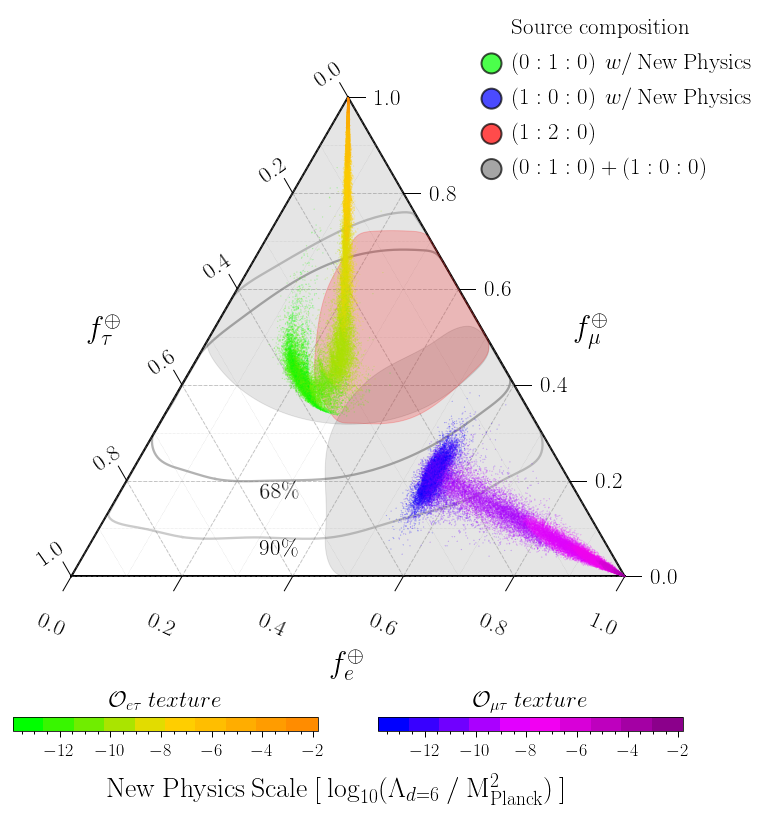

In [24]:
# Figure
fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(2, 1, height_ratios=[40, 1])
gs.update(hspace=0.3, wspace=0.15)

# Axis
ax = fig.add_subplot(gs[0])
ax_labels = [r'$f_{e}^{\oplus}$', r'$f_{\mu}^{\oplus}$', r'$f_{\tau}^{\oplus}$']
tax = plot_utils.get_tax(ax, scale=nbins, ax_labels=ax_labels)

coverages = {68: 'grey', 90: 'darkgrey'}
for cov in coverages.iterkeys():
    plot_utils.flavour_contour(
        frs = flavour_ratios,
        ax = ax,
        nbins = nbins,
        coverage = cov,
        linewidth = 2.3,
        color = coverages[cov],
        alpha=0.6,
        zorder=0
    )

# Lines
marker_style = dict(
    linestyle=' ', color='darkorange', linewidth=1.2,
    markersize=14, zorder=0
)

# Trajectories
tax.scatter(T13_010[:,:-1]*nbins, marker='o', s=0.03, color=color_010, zorder=5)
tax.scatter(T23_100[:,:-1]*nbins, marker='o', s=0.03, color=color_100, zorder=5)

# SM
#tax.scatter(SM_120*nbins, marker='o', s=0.03, alpha=0.06, color='red', zorder=2)

SM_010100 = np.concatenate([SM_100, SM_010])
plot_utils.flavour_contour(
    frs = SM_120,
    ax = ax,
    fill = True,
    nbins = nbins,
    coverage = 100,
    linewidth = 1,
    color = 'red',
    alpha = 0.2,
    zorder = 3
)
plot_utils.flavour_contour(
    frs = SM_100,
    ax = ax,
    fill = True,
    nbins = nbins,
    coverage = 100,
    linewidth = 1,
    color = 'black',
    alpha = 0.1,
    zorder = 2
)
plot_utils.flavour_contour(
    frs = SM_010,
    ax = ax,
    fill = True,
    nbins = nbins,
    coverage = 100,
    linewidth = 1,
    color = 'black',
    alpha = 0.1,
    zorder = 2
)
#tax.scatter(SM_100*nbins, marker='o', s=0.09, alpha=0.12, color='lightgrey', zorder=0)
#tax.scatter(SM_010*nbins, marker='o', s=0.09, alpha=0.12, color='lightgrey', zorder=0)

# Text
#ax.text(0.63, 0.46, r'$\mathcal{O}_{e\mu}$', fontsize=fontsize,
#       rotation=0, verticalalignment='center')
ax.text(0.34*nbins, 0.143*nbins, r'$68\%$', fontsize=fontsize, rotation=3)
ax.text(0.34*nbins, 0.038*nbins, r'$90\%$', fontsize=fontsize, rotation=0)

# Legend
l_size = fontsize
legend_elements = []
legend_elements.append(
    Circle((0., 0.), 0.1, facecolor='lime', alpha=0.7, edgecolor='k',
           linewidth=2., label=r'$\left (0:1:0\right )\:w/\:{\rm New\:Physics}$')
)
legend_elements.append(
    Circle((0., 0.), 0.1, facecolor='blue', alpha=0.7, edgecolor='k',
           linewidth=2., label=r'$\left (1:0:0\right )\:w/\:{\rm New\:Physics}$')
)
legend_elements.append(
    Circle((0., 0.), 0.1, facecolor='red', alpha=0.7, edgecolor='k',
           linewidth=2., label=r'$\left (1:2:0\right )$')
)
legend_elements.append(
    Circle((0., 0.), 0.1, facecolor='grey', alpha=0.7, edgecolor='k',
           linewidth=2., label=r'$\left (0:1:0\right ) + \left (1:0:0\right )$')
)
legend = plt.legend(handles=legend_elements, loc=(0.65, 0.8),
                    title='Source composition',
                    fontsize=l_size,
                    handler_map={Circle: HandlerCircle()})
plt.setp(legend.get_title(), fontsize=l_size)
legend.get_frame().set_linestyle('-')

# Colorbar
gs00 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[1])
ax0 = fig.add_subplot(gs00[0])
cb = mpl.colorbar.ColorbarBase(ax0, cmap=cmap_010, norm=norm, orientation='horizontal')
cb.ax.tick_params(labelsize=fontsize-5)
ax0.text(0.5, 2, r'$\mathcal{O}_{e\tau}\:texture$', fontsize=fontsize,
         rotation=0, verticalalignment='center', horizontalalignment='center')


ax1 = fig.add_subplot(gs00[1])
cb = mpl.colorbar.ColorbarBase(ax1, cmap=cmap_100, norm=norm, orientation='horizontal')
cb.ax.tick_params(labelsize=fontsize-5)
#cb.set_label(r'${\rm New\:Physics\:Scale}\:[\:{\rm log}_{10} (\Lambda^{-1}_{d=6}\:/\:{\rm GeV}^{-2})\: ]$',
#            fontsize=fontsize+5, labelpad=20, horizontalalignment='left')
ax1.text(0.5, 2, r'$\mathcal{O}_{\mu\tau}\:texture$', fontsize=fontsize,
         rotation=0, verticalalignment='center', horizontalalignment='center')

fig.text(0.5, 0.038, r'${\rm New\:Physics\:Scale}\:[\:{\rm log}_{10} (\Lambda_{d=6}\:/\:{\rm M}^{2}_{\rm Planck})\: ]$',
         fontsize=fontsize+5, horizontalalignment='center')

# save
fig.savefig('./plots/fig2.png', bbox_inches='tight', dpi=150)
#fig.savefig('./plots/fig2.pdf', bbox_inches='tight', dpi=150)

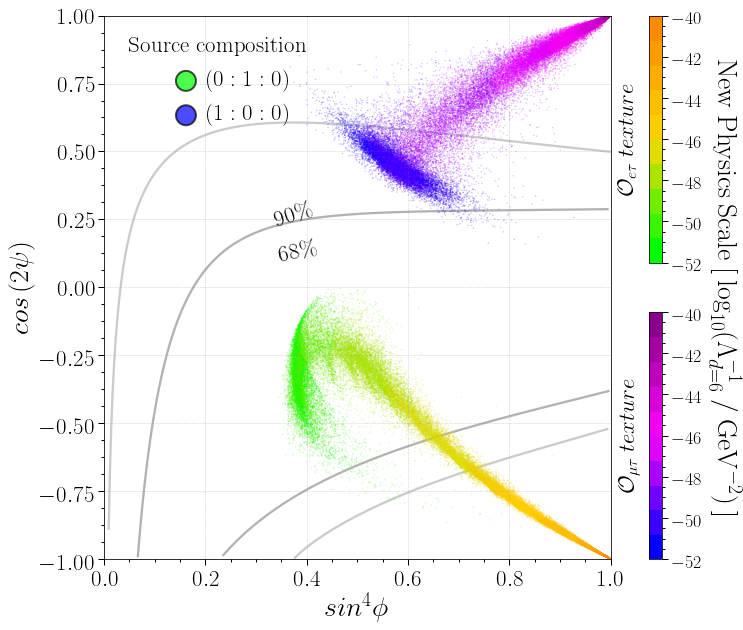

In [13]:
# Figure
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(1, 2, width_ratios=[40, 1])
gs.update(hspace=0.3, wspace=0.15)

ax = fig.add_subplot(gs[0])

ax.set_xlim(0, 1)
ax.set_ylim(-1, 1)

ax.tick_params(axis='x', labelsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize)

ax.set_xlabel(r'$sin^4\phi$', fontsize=fontsize+5)
ax.set_ylabel(r'$cos\left (2\psi\right )$', fontsize=fontsize+5)

for ymaj in ax.yaxis.get_majorticklocs():
    ax.axhline(y=ymaj, ls='--', color='gray', alpha=0.4, linewidth=0.5)
for xmaj in ax.xaxis.get_majorticklocs():
    ax.axvline(x=xmaj, ls='--', color='gray', alpha=0.4, linewidth=0.5)

# HESE data
ax.plot(contour_68_upper_an[:,0], contour_68_upper_an[:,1], linewidth=2.3, color='grey', zorder=0, alpha=0.6)
ax.plot(contour_68_lower_an[:,0], contour_68_lower_an[:,1], linewidth=2.3, color='grey', zorder=0, alpha=0.6)
ax.plot(contour_90_upper_an[:,0], contour_90_upper_an[:,1], linewidth=2.3, color='darkgrey', zorder=0, alpha=0.6)
ax.plot(contour_90_lower_an[:,0], contour_90_lower_an[:,1], linewidth=2.3, color='darkgrey', zorder=0, alpha=0.6)

# Plot
ax.scatter(T13_010_an[:,0], T13_010_an[:,1], marker='o', s=0.03, color=color_010)
ax.scatter(T23_100_an[:,0], T23_100_an[:,1], marker='o', s=0.03, color=color_100)

# Legend
l_size = fontsize
legend_elements = []
legend_elements.append(
    Circle((0., 0.), 0.1, facecolor='lime', alpha=0.7, edgecolor='k',
           linewidth=2., label=r'$\left (0:1:0\right )$')
)
legend_elements.append(
    Circle((0., 0.), 0.1, facecolor='blue', alpha=0.7, edgecolor='k',
           linewidth=2., label=r'$\left (1:0:0\right )$')
)
legend = plt.legend(handles=legend_elements, loc=(0.03, 0.78),
                    title='Source composition',
                    fontsize=l_size,
                    handler_map={Circle: HandlerCircle()})
plt.setp(legend.get_title(), fontsize=l_size)
legend.get_frame().set_linestyle('-')

# Colorbar
gs00 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[1])
ax0 = fig.add_subplot(gs00[0])
cb = mpl.colorbar.ColorbarBase(ax0, cmap=cmap_010, norm=norm)
cb.ax.tick_params(labelsize=fontsize-5)
ax0.text(-1.5, 0.5, r'$\mathcal{O}_{e\tau}\:texture$', fontsize=fontsize,
         rotation=90, verticalalignment='center', horizontalalignment='center')


ax1 = fig.add_subplot(gs00[1])
cb = mpl.colorbar.ColorbarBase(ax1, cmap=cmap_100, norm=norm)
cb.ax.tick_params(labelsize=fontsize-5)
ax1.text(-1.5, 0.5, r'$\mathcal{O}_{\mu\tau}\:texture$', fontsize=fontsize,
         rotation=90, verticalalignment='center', horizontalalignment='center')

fig.text(0.98, 0.5, r'${\rm New\:Physics\:Scale}\:[\:{\rm log}_{10} (\Lambda^{-1}_{d=6}\:/\:{\rm GeV}^{-2})\: ]$',
         fontsize=fontsize+5, horizontalalignment='center', verticalalignment='center', rotation=-90)

# Text
ax.text(0.34, 0.12, r'$68\%$', fontsize=fontsize, rotation=12)
ax.text(0.33, 0.26, r'$90\%$', fontsize=fontsize, rotation=18)

fig.savefig('./plots/fr_an_trajectory.png', bbox_inches='tight', dpi=150)

In [40]:
sc = np.linspace(-52, -40, 1000)
energy = 1e6
    
s = [0, 1, 0]
frs_010 = []
for x in sc:
    u = fr_utils.params_to_BSMu(x, fix_mixing=MixingScenario.T13, dim=6, energy=energy)
    frs_010.append(fr_utils.u_to_fr(s, np.array(u, dtype=np.complex128)))
frs_010 = np.vstack(frs_010)

s = [1, 0, 0]
frs_100 = []
for x in sc:
    u = fr_utils.params_to_BSMu(x, fix_mixing=MixingScenario.T23, dim=6, energy=energy)
    frs_100.append(fr_utils.u_to_fr(s, np.array(u, dtype=np.complex128)))
frs_100 = np.vstack(frs_100)

s = [0, 0, 1]
frs_001 = []
for x in sc:
    u = fr_utils.params_to_BSMu(x, fix_mixing=MixingScenario.T12, dim=6, energy=energy)
    frs_001.append(fr_utils.u_to_fr(s, np.array(u, dtype=np.complex128)))
frs_001 = np.vstack(frs_001)

In [41]:
frs_010_an = np.array(map(fr_utils.fr_to_angles, frs_010))
frs_100_an = np.array(map(fr_utils.fr_to_angles, frs_100))
frs_001_an = np.array(map(fr_utils.fr_to_angles, frs_001))

norm = mpl.colors.Normalize(vmin=-52, vmax=-40)

color_fe_010 = map(alp, map(cmap_010, map(norm, sc)))
color_fe_100 = map(alp, map(cmap_100, map(norm, sc)))
color_fe_001 = map(alp, map(cmap_001, map(norm, sc)))

In [53]:
print frs_001[-20:]
print frs_001_an[-20:]

[[5.84194871e-11 1.56515735e-10 1.00000000e+00]
 [5.52751705e-11 1.48093239e-10 1.00000000e+00]
 [5.23001026e-11 1.40123967e-10 1.00000000e+00]
 [4.94851722e-11 1.32583532e-10 1.00000000e+00]
 [4.68217589e-11 1.25448858e-10 1.00000000e+00]
 [4.43017062e-11 1.18698112e-10 1.00000000e+00]
 [4.19172970e-11 1.12310634e-10 1.00000000e+00]
 [3.96612294e-11 1.06266876e-10 1.00000000e+00]
 [3.75265948e-11 1.00548344e-10 1.00000000e+00]
 [3.55068565e-11 9.51375370e-11 1.00000000e+00]
 [3.35958296e-11 9.00178958e-11 1.00000000e+00]
 [3.17876624e-11 8.51737530e-11 1.00000000e+00]
 [3.00768181e-11 8.05902837e-11 1.00000000e+00]
 [2.84580580e-11 7.62534611e-11 1.00000000e+00]
 [2.69264252e-11 7.21500127e-11 1.00000000e+00]
 [2.54772301e-11 6.82673806e-11 1.00000000e+00]
 [2.41060352e-11 6.45936825e-11 1.00000000e+00]
 [2.28086419e-11 6.11176752e-11 1.00000000e+00]
 [2.15810779e-11 5.78287209e-11 1.00000000e+00]
 [2.04195844e-11 5.47167540e-11 1.00000000e+00]]
[[ 4.61971319e-20 -4.56399023e-01]
 [ 4

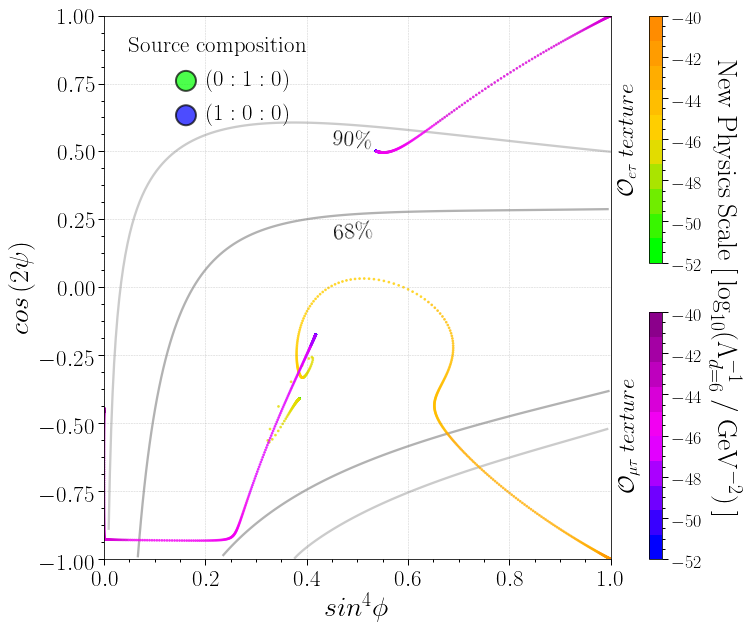

In [42]:
# Figure
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(1, 2, width_ratios=[40, 1])
gs.update(hspace=0.3, wspace=0.15)

ax = fig.add_subplot(gs[0])

ax.set_xlim(0, 1)
ax.set_ylim(-1, 1)

ax.tick_params(axis='x', labelsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize)

ax.set_xlabel(r'$sin^4\phi$', fontsize=fontsize+5)
ax.set_ylabel(r'$cos\left (2\psi\right )$', fontsize=fontsize+5)

for ymaj in ax.yaxis.get_majorticklocs():
    ax.axhline(y=ymaj, ls='--', color='gray', alpha=0.4, linewidth=0.5)
for xmaj in ax.xaxis.get_majorticklocs():
    ax.axvline(x=xmaj, ls='--', color='gray', alpha=0.4, linewidth=0.5)

# HESE data
ax.plot(contour_68_upper_an[:,0], contour_68_upper_an[:,1], linewidth=2.3, color='grey', zorder=0, alpha=0.6)
ax.plot(contour_68_lower_an[:,0], contour_68_lower_an[:,1], linewidth=2.3, color='grey', zorder=0, alpha=0.6)
ax.plot(contour_90_upper_an[:,0], contour_90_upper_an[:,1], linewidth=2.3, color='darkgrey', zorder=0, alpha=0.6)
ax.plot(contour_90_lower_an[:,0], contour_90_lower_an[:,1], linewidth=2.3, color='darkgrey', zorder=0, alpha=0.6)

# Plot
ax.scatter(frs_010_an[:,0], frs_010_an[:,1], marker='o', s=3, color=color_fe_010)
ax.scatter(frs_100_an[:,0], frs_100_an[:,1], marker='o', s=3, color=color_fe_100)
ax.scatter(frs_001_an[:,0], frs_001_an[:,1], marker='o', s=3, color=color_fe_001)

# Legend
l_size = fontsize
legend_elements = []
legend_elements.append(
    Circle((0., 0.), 0.1, facecolor='lime', alpha=0.7, edgecolor='k',
           linewidth=2., label=r'$\left (0:1:0\right )$')
)
legend_elements.append(
    Circle((0., 0.), 0.1, facecolor='blue', alpha=0.7, edgecolor='k',
           linewidth=2., label=r'$\left (1:0:0\right )$')
)
legend = plt.legend(handles=legend_elements, loc=(0.03, 0.78),
                    title='Source composition',
                    fontsize=l_size,
                    handler_map={Circle: HandlerCircle()})
plt.setp(legend.get_title(), fontsize=l_size)
legend.get_frame().set_linestyle('-')

# Colorbar
gs00 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[1])
ax0 = fig.add_subplot(gs00[0])
cb = mpl.colorbar.ColorbarBase(ax0, cmap=cmap_010, norm=norm)
cb.ax.tick_params(labelsize=fontsize-5)
ax0.text(-1.5, 0.5, r'$\mathcal{O}_{e\tau}\:texture$', fontsize=fontsize,
         rotation=90, verticalalignment='center', horizontalalignment='center')


ax1 = fig.add_subplot(gs00[1])
cb = mpl.colorbar.ColorbarBase(ax1, cmap=cmap_100, norm=norm)
cb.ax.tick_params(labelsize=fontsize-5)
ax1.text(-1.5, 0.5, r'$\mathcal{O}_{\mu\tau}\:texture$', fontsize=fontsize,
         rotation=90, verticalalignment='center', horizontalalignment='center')

fig.text(0.98, 0.5, r'${\rm New\:Physics\:Scale}\:[\:{\rm log}_{10} (\Lambda^{-1}_{d=6}\:/\:{\rm GeV}^{-2})\: ]$',
         fontsize=fontsize+5, horizontalalignment='center', verticalalignment='center', rotation=-90)

# Text
ax.text(0.45, 0.185, r'$68\%$', fontsize=fontsize, rotation=5)
ax.text(0.45, 0.52, r'$90\%$', fontsize=fontsize, rotation=-4)

fig.savefig('./plots/fr_an_fe_trajectory.png', bbox_inches='tight', dpi=150)

In [17]:
MCMC_010_sc = np.load('./chains/mcmc_chain_DIM6_sfr_0_1_0_mfr_1_1_1_MixingScenario.T13.npy')[:,-1]
MCMC_010_frs = np.load('./chains/mcmc_chain_DIM6_sfr_0_1_0_mfr_1_1_1_MixingScenario.T13_proc.npy')
print MCMC_010_frs.shape

MCMC_100_sc = np.load('./chains/mcmc_chain_DIM6_sfr_1_0_0_mfr_1_1_1_MixingScenario.T23.npy')[:,-1]
MCMC_100_frs = np.load('./chains/mcmc_chain_DIM6_sfr_1_0_0_mfr_1_1_1_MixingScenario.T23_proc.npy')
print MCMC_100_frs.shape

(60000, 3)
(60000, 3)


In [18]:
#min_scale = np.min(MCMC_100_sc)
#max_scale = np.max(MCMC_100_sc)
min_scale = -52
max_scale = -40
norm = mpl.colors.Normalize(vmin=min_scale, vmax=max_scale)

color_MCMC_100 = map(alp, map(cmap_100, map(norm, MCMC_100_sc)))
color_MCMC_010 = map(alp, map(cmap_010, map(norm, MCMC_010_sc)))

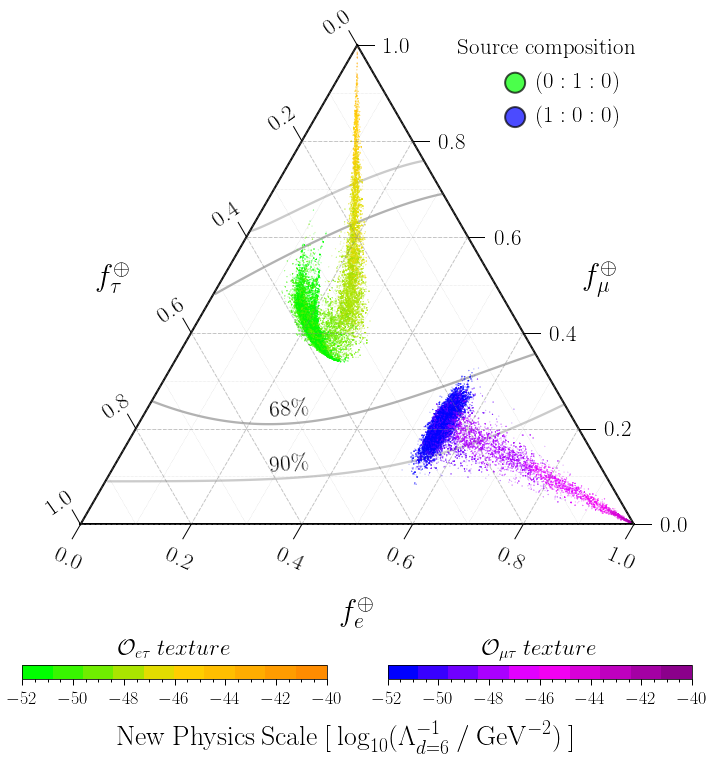

In [19]:
# Figure
fig = plt.figure(figsize=(12, 12))
#gs = gridspec.GridSpec(1, 2, width_ratios=[40, 1])
gs = gridspec.GridSpec(2, 1, height_ratios=[40, 1])
gs.update(hspace=0.3, wspace=0.15)

ax = fig.add_subplot(gs[0])
ax.set_aspect('equal')

# Boundary and Gridlines
scale = 1
fig, tax = ternary.figure(ax=ax, scale=scale)

# Draw Boundary and Gridlines
tax.boundary(linewidth=2.0)
tax.gridlines(color='grey', multiple=scale/5., linewidth=1.0, alpha=0.4, ls='--')
tax.gridlines(color='grey', multiple=scale/10., linewidth=0.5, alpha=0.4, ls=':')

# Set Axis labels and Title
fontsize = 23
tax.left_axis_label(r"$f_{\tau}^{\oplus}$", fontsize=fontsize+8, offset=0.2, rotation=0)
tax.right_axis_label(r"$f_{\mu}^{\oplus}$", fontsize=fontsize+8, offset=0.2, rotation=0)
tax.bottom_axis_label(r"$f_{e}^{\oplus}$", fontsize=fontsize+8, position=(0.55, -0.20/2, 0.5), rotation=0)

# Remove default Matplotlib axis
tax.get_axes().axis('off')
tax.clear_matplotlib_ticks()

# Plot
#tax.scatter(SM_120, marker='o', s=0.03, alpha=0.3, color='red')
#tax.scatter([[0, 1, 0]], marker='*', s=500, alpha=1.0, color='green', zorder=100)
#tax.scatter([[1, 0, 0]], marker='*', s=500, alpha=1.0, color='blue', zorder=100)

# Contour
tax.plot(contour_68_upper, linewidth=2.3, color='grey', zorder=0, alpha=0.6)
tax.plot(contour_68_lower, linewidth=2.3, color='grey', zorder=0, alpha=0.6)
tax.plot(contour_90_upper, linewidth=2.3, color='darkgrey', zorder=0, alpha=0.6)
tax.plot(contour_90_lower, linewidth=2.3, color='darkgrey', zorder=0, alpha=0.6)

# Lines
marker_style = dict(
    linestyle=' ', color='darkorange', linewidth=1.2,
    markersize=14, zorder=0
)

# Trajectories
tax.scatter(MCMC_010_frs, marker='o', s=0.03, color=color_MCMC_010)
tax.scatter(MCMC_100_frs, marker='o', s=0.03, color=color_MCMC_100)

# Text
#ax.text(0.63, 0.46, r'$\mathcal{O}_{e\mu}$', fontsize=fontsize,
#       rotation=0, verticalalignment='center')
ax.text(0.34, 0.2, r'$68\%$', fontsize=fontsize, rotation=5)
ax.text(0.34, 0.1, r'$90\%$', fontsize=fontsize, rotation=5)

# Legend
l_size = fontsize
legend_elements = []
#legend_elements.append(
#    Circle((0., 0.), 0.1, facecolor='red', alpha=0.7, edgecolor='k',
#           linewidth=2., label=r'$\left (1:2:0\right )$')
#)
legend_elements.append(
    Circle((0., 0.), 0.1, facecolor='lime', alpha=0.7, edgecolor='k',
           linewidth=2., label=r'$\left (0:1:0\right )$')
)
legend_elements.append(
    Circle((0., 0.), 0.1, facecolor='blue', alpha=0.7, edgecolor='k',
           linewidth=2., label=r'$\left (1:0:0\right )$')
)
legend = plt.legend(handles=legend_elements, loc=(0.65, 0.8),
                    title='Source composition',
                    fontsize=l_size,
                    handler_map={Circle: HandlerCircle()})
plt.setp(legend.get_title(), fontsize=l_size)
legend.get_frame().set_linestyle('-')

# Colorbar
gs00 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[1])
ax0 = fig.add_subplot(gs00[0])
cb = mpl.colorbar.ColorbarBase(ax0, cmap=cmap_010, norm=norm, orientation='horizontal')
cb.ax.tick_params(labelsize=fontsize-5)
ax0.text(0.5, 2, r'$\mathcal{O}_{e\tau}\:texture$', fontsize=fontsize,
         rotation=0, verticalalignment='center', horizontalalignment='center')


ax1 = fig.add_subplot(gs00[1])
cb = mpl.colorbar.ColorbarBase(ax1, cmap=cmap_100, norm=norm, orientation='horizontal')
cb.ax.tick_params(labelsize=fontsize-5)
#cb.set_label(r'${\rm New\:Physics\:Scale}\:[\:{\rm log}_{10} (\Lambda^{-1}_{d=6}\:/\:{\rm GeV}^{-2})\: ]$',
#            fontsize=fontsize+5, labelpad=20, horizontalalignment='left')
ax1.text(0.5, 2, r'$\mathcal{O}_{\mu\tau}\:texture$', fontsize=fontsize,
         rotation=0, verticalalignment='center', horizontalalignment='center')

fig.text(0.5, 0.038, r'${\rm New\:Physics\:Scale}\:[\:{\rm log}_{10} (\Lambda^{-1}_{d=6}\:/\:{\rm GeV}^{-2})\: ]$',
         fontsize=fontsize+5, horizontalalignment='center')

# Set ticks
tax.ticks(axis='blr', multiple=scale/5., linewidth=1, offset=0.03,
          fontsize=fontsize, tick_formats='%.1f')

tax._redraw_labels()

# save
#fig.savefig('./plots/fr_trajectory.png', bbox_inches='tight', dpi=150)
#fig.savefig('./plots/fr_trajectory.pdf', bbox_inches='tight', dpi=150)